## Installing library

In [1]:
!pip install -q wfdb

In [4]:
!pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
    --------------------------------------- 0.1/4.2 MB 1.1 MB/s eta 0:00:04
   ------ --------------------------------- 0.7/4.2 MB 6.0 MB/s eta 0:00:01
   -------------- ------------------------- 1.5/4.2 MB 10.5 MB/s eta 0:00:01
   ----------------------- ---------------- 2.4/4.2 MB 11.9 MB/s eta 0:00:01
   -------------------------------- ------- 3.4/4.2 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 14.9 MB/s eta 0:00:00


In [1]:
# Data Handling and Processing
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import pywt
from scipy import stats
import wfdb

In [4]:
import os

def list_all_files(directory_path):
    """
    Lists all files within a given directory.

    Args:
        directory_path: The path to the directory.

    Returns:
        A list of filenames (strings) within the directory.  Returns an empty list if the directory is empty or doesn't exist.
    """
    try:
        filenames = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
        return filenames
    except FileNotFoundError:
        print(f"Error: Directory '{directory_path}' not found.")
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []


# Example usage:  Replace 'Person_01' with your actual directory path.
directory_to_list = 'Person_01'  #Make sure this path is correct relative to your script
all_files = list_all_files(directory_to_list)
print(all_files)

['rec_1.atr', 'rec_1.dat', 'rec_1.hea', 'rec_10.atr', 'rec_10.dat', 'rec_10.hea', 'rec_11.atr', 'rec_11.dat', 'rec_11.hea', 'rec_12.atr', 'rec_12.dat', 'rec_12.hea', 'rec_13.atr', 'rec_13.dat', 'rec_13.hea', 'rec_14.atr', 'rec_14.dat', 'rec_14.hea', 'rec_15.atr', 'rec_15.dat', 'rec_15.hea', 'rec_16.atr', 'rec_16.dat', 'rec_16.hea', 'rec_17.atr', 'rec_17.dat', 'rec_17.hea', 'rec_18.atr', 'rec_18.dat', 'rec_18.hea', 'rec_19.atr', 'rec_19.dat', 'rec_19.hea', 'rec_2.atr', 'rec_2.dat', 'rec_2.hea', 'rec_20.atr', 'rec_20.dat', 'rec_20.hea', 'rec_3.atr', 'rec_3.dat', 'rec_3.hea', 'rec_4.atr', 'rec_4.dat', 'rec_4.hea', 'rec_5.atr', 'rec_5.dat', 'rec_5.hea', 'rec_6.atr', 'rec_6.dat', 'rec_6.hea', 'rec_7.atr', 'rec_7.dat', 'rec_7.hea', 'rec_8.atr', 'rec_8.dat', 'rec_8.hea', 'rec_9.atr', 'rec_9.dat', 'rec_9.hea']


Available Records: ['rec_1', 'rec_10', 'rec_11', 'rec_12', 'rec_13', 'rec_14', 'rec_15', 'rec_16', 'rec_17', 'rec_18', 'rec_19', 'rec_2', 'rec_20', 'rec_3', 'rec_4', 'rec_5', 'rec_6', 'rec_7', 'rec_8', 'rec_9']


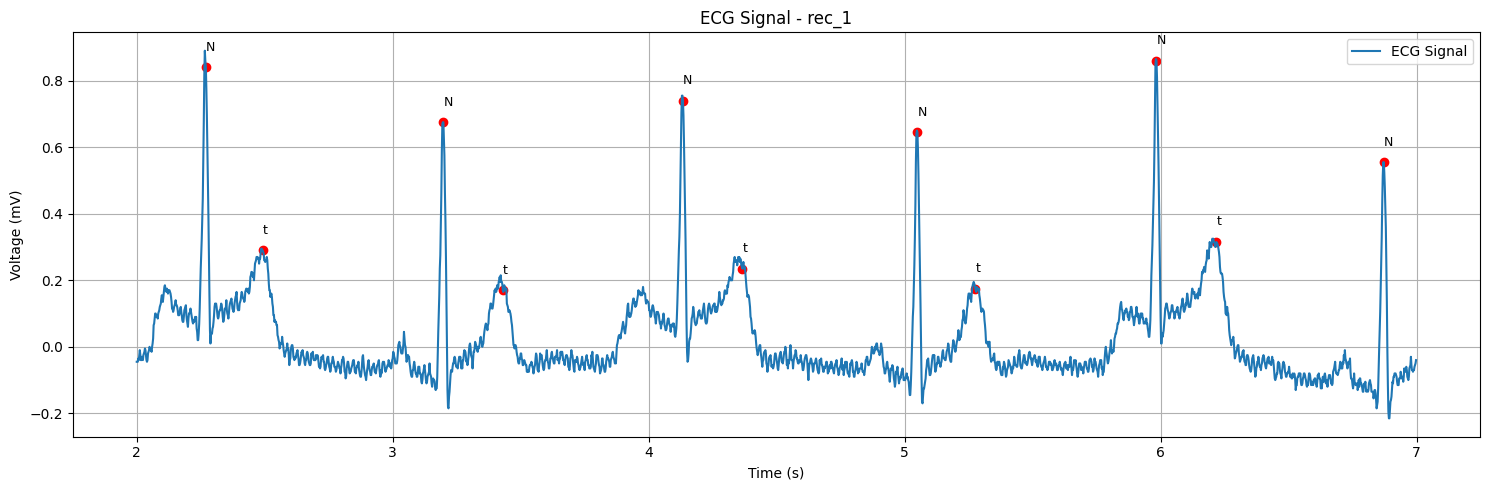

Metadata:
  Sampling rate: 500 Hz
  Duration: 20.00 seconds
  Channels: ['ECG I', 'ECG I filtered']
  Total R-peaks: 20
  Beat types: Counter({'N': 10, 't': 10})
Record  Total R-peaks         Beat types
 rec_1             20 {'N': 10, 't': 10}
rec_10             20 {'N': 10, 't': 10}
rec_11             20 {'N': 10, 't': 10}
rec_12             20 {'N': 10, 't': 10}
rec_13             20 {'N': 10, 't': 10}
rec_14             20 {'N': 10, 't': 10}
rec_15             20 {'N': 10, 't': 10}
rec_16             20 {'N': 10, 't': 10}
rec_17             20 {'N': 10, 't': 10}
rec_18             20 {'N': 10, 't': 10}
rec_19             20 {'N': 10, 't': 10}
 rec_2             20 {'N': 10, 't': 10}
rec_20             20 {'N': 10, 't': 10}
 rec_3             20 {'N': 10, 't': 10}
 rec_4             20 {'N': 10, 't': 10}
 rec_5             20 {'N': 10, 't': 10}
 rec_6             20 {'N': 10, 't': 10}
 rec_7             20 {'N': 10, 't': 10}
 rec_8             20 {'N': 10, 't': 10}
 rec_9            

In [5]:
import wfdb
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# Path to folder containing rec_*.dat/.hea/.atr
DATA_DIR = "./Person_01" 

# Helper to plot a single record
def plot_ecg_record(record_name, show_full_signal=False, zoom_range=(0, 5)):
    record_path = os.path.join(DATA_DIR, record_name)

    # Load signal and annotation
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')

    # Time vector
    fs = record.fs
    times = np.arange(record.sig_len) / fs

    # Get signal (assuming single channel)
    signal = record.p_signal[:, 0] if record.n_sig == 1 else record.p_signal[:, 0]

    # R-peaks
    r_locs = annotation.sample / fs
    r_labels = annotation.symbol

    # Plot
    plt.figure(figsize=(15, 5))

    if show_full_signal:
        plt.plot(times, signal, label='ECG Signal')
        plt.scatter(r_locs, signal[annotation.sample], color='red', label='R-peaks')
    else:
        # Zoomed view
        start_sample = int(zoom_range[0] * fs)
        end_sample = int(zoom_range[1] * fs)
        plt.plot(times[start_sample:end_sample], signal[start_sample:end_sample], label='ECG Signal')
        for idx, sample in enumerate(annotation.sample):
            if start_sample <= sample <= end_sample:
                plt.scatter(sample / fs, signal[sample], color='red')
                plt.text(sample / fs, signal[sample] + 0.05, r_labels[idx], fontsize=9)

    plt.title(f"ECG Signal - {record_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Summary
    print("Metadata:")
    print(f"  Sampling rate: {fs} Hz")
    print(f"  Duration: {record.sig_len / fs:.2f} seconds")
    print(f"  Channels: {record.sig_name}")
    print(f"  Total R-peaks: {len(r_locs)}")
    print(f"  Beat types: {Counter(r_labels)}")

# View all available records
def list_available_records():
    return sorted(set(f.split('.')[0] for f in os.listdir(DATA_DIR) if f.endswith('.hea')))

# Explore all records and count annotations
def summarize_all_records():
    summary = []
    for record_name in list_available_records():
        record_path = os.path.join(DATA_DIR, record_name)
        try:
            ann = wfdb.rdann(record_path, 'atr')
            beat_counts = Counter(ann.symbol)
            summary.append({'Record': record_name, 'Total R-peaks': len(ann.sample), 'Beat types': dict(beat_counts)})
        except Exception as e:
            summary.append({'Record': record_name, 'Total R-peaks': 'Error', 'Beat types': str(e)})
    return pd.DataFrame(summary)

# ---- Example usage ----

# List all records
records = list_available_records()
print("Available Records:", records)

# Plot a record (change name and zoom_range to explore)
plot_ecg_record('rec_1', show_full_signal=False, zoom_range=(2, 7))

# Summary table of all records
summary_df = summarize_all_records()
print(summary_df.to_string(index=False))


In [8]:
records = list_available_records()
for rec in records:
    ann = wfdb.rdann(DATA_DIR +"/" + rec, 'atr')
    print(f"{rec}: {len(ann.sample)} R-peaks")


rec_1: 20 R-peaks
rec_10: 20 R-peaks
rec_11: 20 R-peaks
rec_12: 20 R-peaks
rec_13: 20 R-peaks
rec_14: 20 R-peaks
rec_15: 20 R-peaks
rec_16: 20 R-peaks
rec_17: 20 R-peaks
rec_18: 20 R-peaks
rec_19: 20 R-peaks
rec_2: 20 R-peaks
rec_20: 20 R-peaks
rec_3: 20 R-peaks
rec_4: 20 R-peaks
rec_5: 20 R-peaks
rec_6: 20 R-peaks
rec_7: 20 R-peaks
rec_8: 20 R-peaks
rec_9: 20 R-peaks


In [9]:
import wfdb
import os
import pandas as pd
from collections import Counter

# Make sure DATA_DIR and list_available_records() are defined
# Example:
# DATA_DIR = "/your/path/to/Person_01"
# def list_available_records(): ...

def summarize_all_records():
    summary = []

    records = list_available_records()
    for rec in records:
        rec_path = os.path.join(DATA_DIR, rec)

        try:
            # Load signal for duration/sampling info
            record = wfdb.rdrecord(rec_path)
            fs = record.fs
            duration = record.sig_len / fs

            # Load annotations
            ann = wfdb.rdann(rec_path, 'atr')
            r_peaks = ann.sample
            symbols = ann.symbol
            beat_counts = Counter(symbols)

            summary.append({
                'Record': rec,
                'Duration (s)': round(duration, 2),
                'Sampling Rate (Hz)': fs,
                'Total R-Peaks': len(r_peaks),
                'Beat Types': dict(beat_counts)
            })

        except Exception as e:
            summary.append({
                'Record': rec,
                'Duration (s)': 'Error',
                'Sampling Rate (Hz)': 'Error',
                'Total R-Peaks': 'Error',
                'Beat Types': str(e)
            })

    df = pd.DataFrame(summary)
    df = df.sort_values(by="Record")
    return df

# Run it
summary_df = summarize_all_records()

# Display
print(summary_df.to_string(index=False))

Record  Duration (s)  Sampling Rate (Hz)  Total R-Peaks         Beat Types
 rec_1          20.0                 500             20 {'N': 10, 't': 10}
rec_10          20.0                 500             20 {'N': 10, 't': 10}
rec_11          20.0                 500             20 {'N': 10, 't': 10}
rec_12          20.0                 500             20 {'N': 10, 't': 10}
rec_13          20.0                 500             20 {'N': 10, 't': 10}
rec_14          20.0                 500             20 {'N': 10, 't': 10}
rec_15          20.0                 500             20 {'N': 10, 't': 10}
rec_16          20.0                 500             20 {'N': 10, 't': 10}
rec_17          20.0                 500             20 {'N': 10, 't': 10}
rec_18          20.0                 500             20 {'N': 10, 't': 10}
rec_19          20.0                 500             20 {'N': 10, 't': 10}
 rec_2          20.0                 500             20 {'N': 10, 't': 10}
rec_20          20.0     

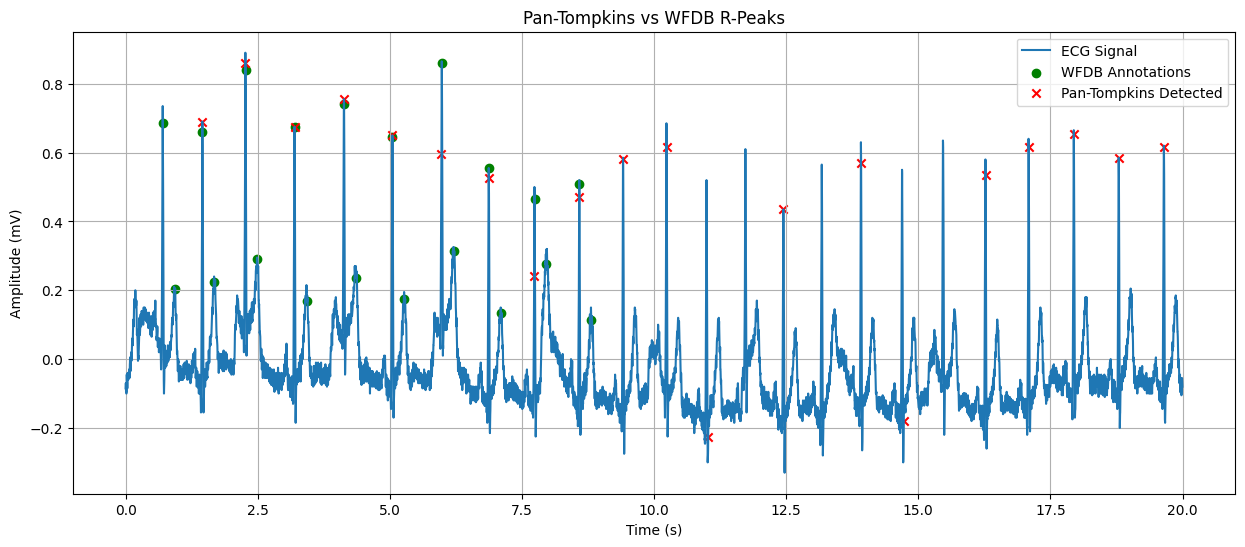

Pan-Tompkins R-peaks: 20
WFDB R-peaks: 20


In [23]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import wfdb
import os

# Set path to your extracted folder
record_path = "Person_01/rec_1"  # <-- change this

record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(ecg_signal)) / fs

# --- Pan-Tompkins ---
def bandpass_filter(sig, fs):
    nyq = 0.5 * fs
    low = 5 / nyq
    high = 15 / nyq
    b, a = signal.butter(1, [low, high], btype='band')
    return signal.filtfilt(b, a, sig)

def derivative(sig):
    return np.ediff1d(sig, to_end=0)

def squaring(sig):
    return sig ** 2

def moving_window_integration(sig, window_ms, fs):
    window_size = int(window_ms * fs / 1000)
    window = np.ones(window_size) / window_size
    return np.convolve(sig, window, mode='same')

def detect_peaks(integrated_sig, fs):
    threshold = np.mean(integrated_sig)
    min_distance = int(0.787 * fs) 
    peaks, _ = signal.find_peaks(integrated_sig, height=threshold, distance=min_distance)
    return peaks

filtered = bandpass_filter(ecg_signal, fs)
diff = derivative(filtered)
squared = squaring(diff)
mwi = moving_window_integration(squared, 150, fs)
r_peaks = detect_peaks(mwi, fs)

# Load ground truth annotations
ann = wfdb.rdann(record_path, 'atr')
true_r_peaks = ann.sample

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(true_r_peaks / fs, ecg_signal[true_r_peaks], color='green', label='WFDB Annotations', marker='o')
plt.scatter(r_peaks / fs, ecg_signal[r_peaks], color='red', label='Pan-Tompkins Detected', marker='x')
plt.title("Pan-Tompkins vs WFDB R-Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

print("Pan-Tompkins R-peaks:", len(r_peaks))
print("WFDB R-peaks:", len(true_r_peaks))


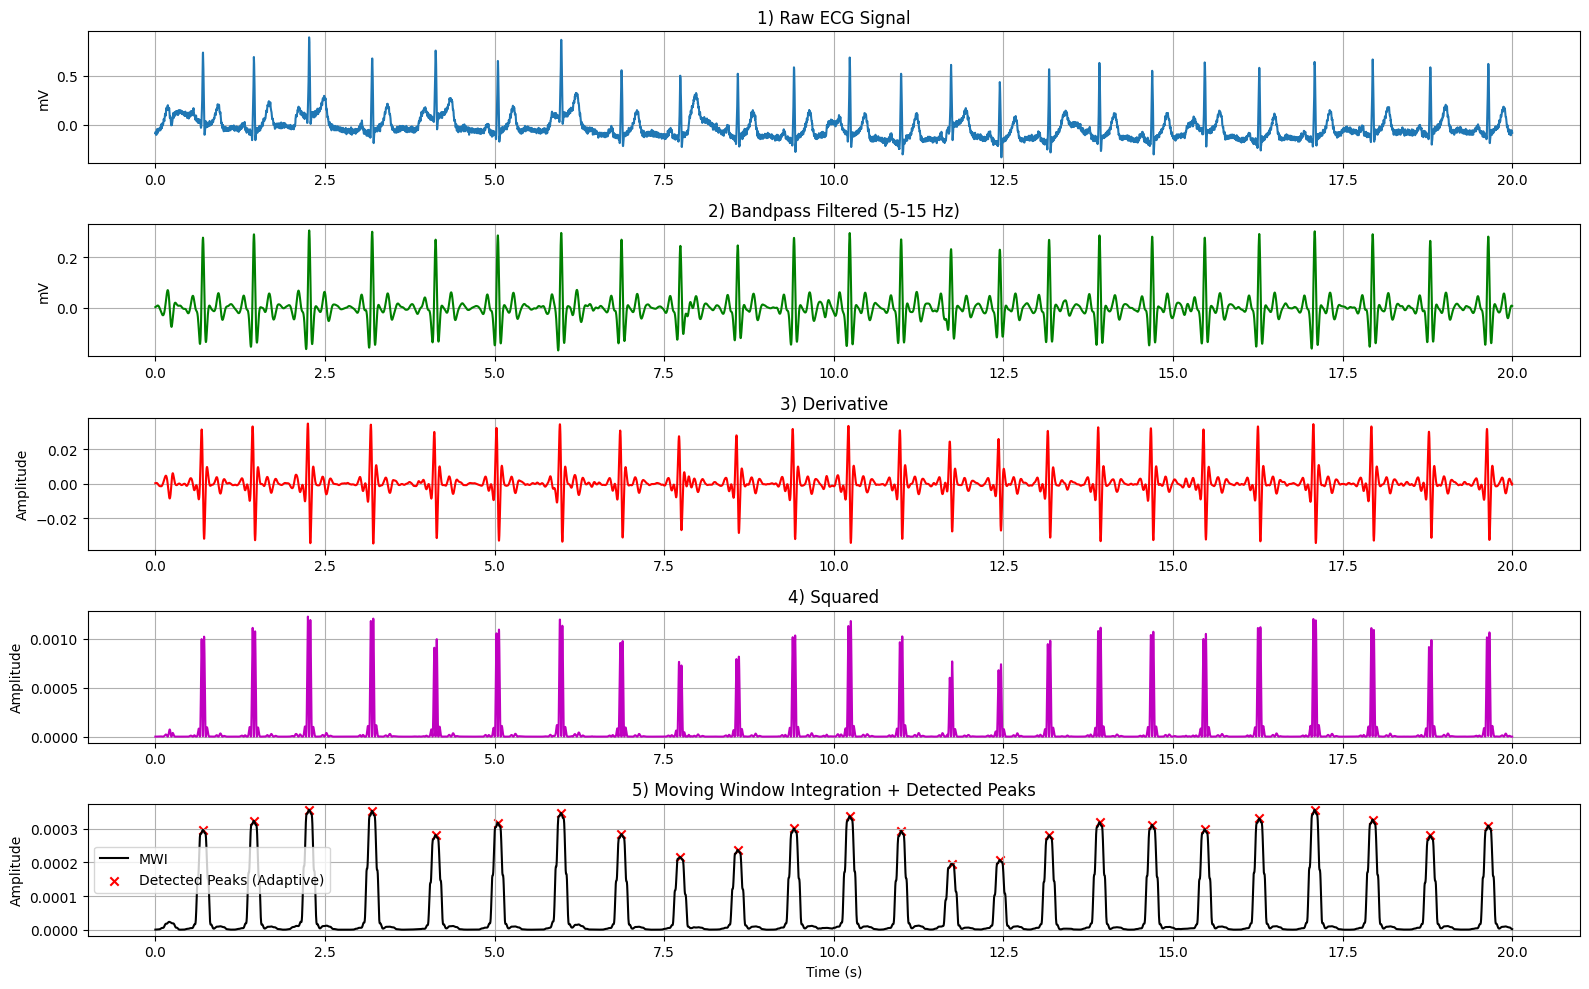

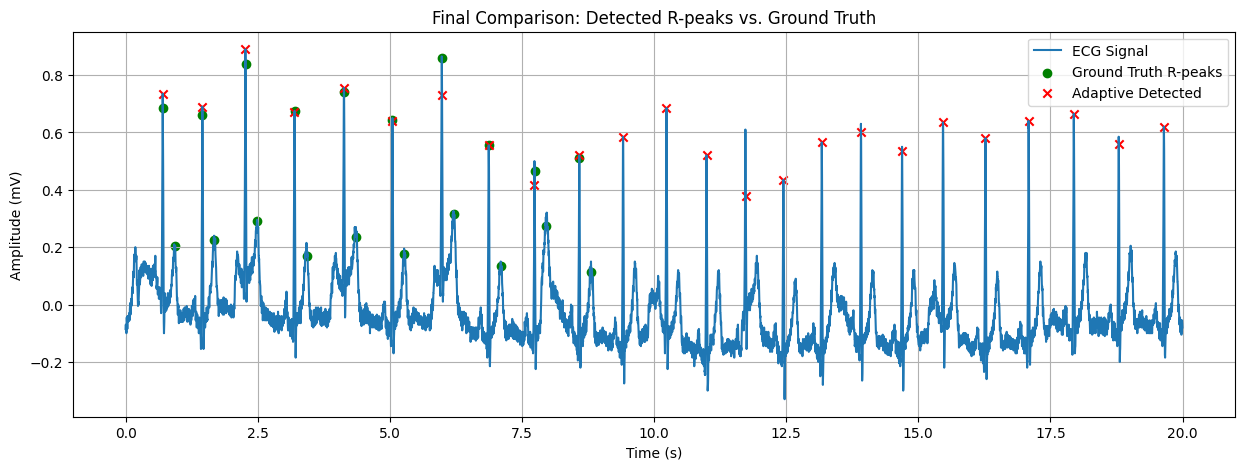

Adaptive Pan-Tompkins R-peaks detected: 24
WFDB R-peaks (ground truth): 20


In [ ]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy import signal

def bandpass_filter(sig, fs, lowcut=5, highcut=15, order=2):
    """
    Bandpass filter: default 5-15 Hz (Pan-Tompkins range).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, sig)

def derivative(sig):
    """
    Approximate derivative using a simple difference.
    """
    # np.ediff1d computes sig[i+1] - sig[i]
    return np.ediff1d(sig, to_end=0)

def squaring(sig):
    """
    Nonlinear squaring to emphasize large differences (QRS slopes).
    """
    return sig ** 2

def moving_window_integration(sig, window_ms, fs):
    """
    Simple moving average for a given window size (ms).
    """
    window_size = int(window_ms * fs / 1000)
    window = np.ones(window_size) / window_size
    return np.convolve(sig, window, mode='same')

def detect_peaks_adaptive(integrated_sig, fs, initial_threshold=None):
    """
    Adaptive thresholding approach (simplified Pan-Tompkins):
    - We maintain two running estimates:
      1) SPKI (Signal Peak)
      2) NPKI (Noise Peak)
    - After each detection, we update SPKI or NPKI.
    - The detection threshold is updated as:
        threshold_i = NPKI + 0.25*(SPKI - NPKI)
    """
    # Minimum distance between R-peaks: ~200-300 ms typical
    min_distance = int(0.25 * fs)
    
    # Initialize thresholds
    if initial_threshold is None:
        # For a first guess, we could use a fraction of the max
        initial_threshold = 0.5 * np.max(integrated_sig)
    threshold_i = initial_threshold
    
    SPKI = initial_threshold  # Signal Peak initial guess
    NPKI = 0.1 * initial_threshold  # Noise Peak initial guess
    
    r_peaks = []
    for i in range(1, len(integrated_sig)):
        if integrated_sig[i] > threshold_i:
            # Potential R-peak
            r_peaks.append(i)
            # Update signal peak
            SPKI = 0.125 * integrated_sig[i] + 0.875 * SPKI
            # Update threshold
            threshold_i = NPKI + 0.25 * (SPKI - NPKI)
        else:
            # Update noise peak
            NPKI = 0.125 * integrated_sig[i] + 0.875 * NPKI
            # Update threshold
            threshold_i = NPKI + 0.25 * (SPKI - NPKI)
    
    # Enforce minimum distance (if two peaks are too close, keep the larger one)
    final_peaks = []
    last_peak = -min_distance
    for peak_idx in r_peaks:
        if peak_idx - last_peak > min_distance:
            final_peaks.append(peak_idx)
            last_peak = peak_idx
        else:
            # If they're too close, choose the one with the higher amplitude in integrated_sig
            if integrated_sig[peak_idx] > integrated_sig[final_peaks[-1]]:
                final_peaks[-1] = peak_idx
                last_peak = peak_idx
    
    return np.array(final_peaks)

# ---------------------------------------------------------------------
# Example usage with WFDB data:
# ---------------------------------------------------------------------
# Adjust the record_path to point to your data.
record_path = "Person_01/rec_1"  # e.g., "mitdb/100" if you have MIT-BIH
record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(ecg_signal)) / fs

# Ground truth R-peak annotations (if available)
ann = wfdb.rdann(record_path, 'atr')
true_r_peaks = ann.sample

# -------------------------
# 1) Bandpass Filter
# -------------------------
filtered_sig = bandpass_filter(ecg_signal, fs, lowcut=5, highcut=15, order=2)

# -------------------------
# 2) Derivative
# -------------------------
diff_sig = derivative(filtered_sig)

# -------------------------
# 3) Squaring
# -------------------------
squared_sig = squaring(diff_sig)

# -------------------------
# 4) Moving Window Integration
# -------------------------
mwi_sig = moving_window_integration(squared_sig, window_ms=150, fs=fs)

# -------------------------
# 5) Adaptive Threshold Detection
# -------------------------
r_peaks_adaptive = detect_peaks_adaptive(mwi_sig, fs)

# ---------------------------------------------------------------------
# Debug/Visualization: Plot each step to see how signals evolve
# ---------------------------------------------------------------------
plt.figure(figsize=(16, 10))

plt.subplot(5, 1, 1)
plt.plot(time, ecg_signal, label='Raw ECG')
plt.title('1) Raw ECG Signal')
plt.ylabel('mV')
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(time, filtered_sig, color='g', label='Bandpass Filtered')
plt.title('2) Bandpass Filtered (5-15 Hz)')
plt.ylabel('mV')
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(time, diff_sig, color='r', label='Derivative')
plt.title('3) Derivative')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(time, squared_sig, color='m', label='Squared')
plt.title('4) Squared')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(5, 1, 5)
plt.plot(time, mwi_sig, color='k', label='MWI')
plt.scatter(r_peaks_adaptive/fs, mwi_sig[r_peaks_adaptive], color='red', marker='x', 
            label='Detected Peaks (Adaptive)')
plt.title('5) Moving Window Integration + Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Final Comparison with Ground Truth
# ---------------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(true_r_peaks/fs, ecg_signal[true_r_peaks], 
            color='green', label='Ground Truth R-peaks', marker='o')
plt.scatter(r_peaks_adaptive/fs, ecg_signal[r_peaks_adaptive], 
            color='red', label='Adaptive Detected', marker='x')
plt.title("Final Comparison: Detected R-peaks vs. Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

print("Adaptive Pan-Tompkins R-peaks detected:", len(r_peaks_adaptive))
print("WFDB R-peaks (ground truth):", len(true_r_peaks))


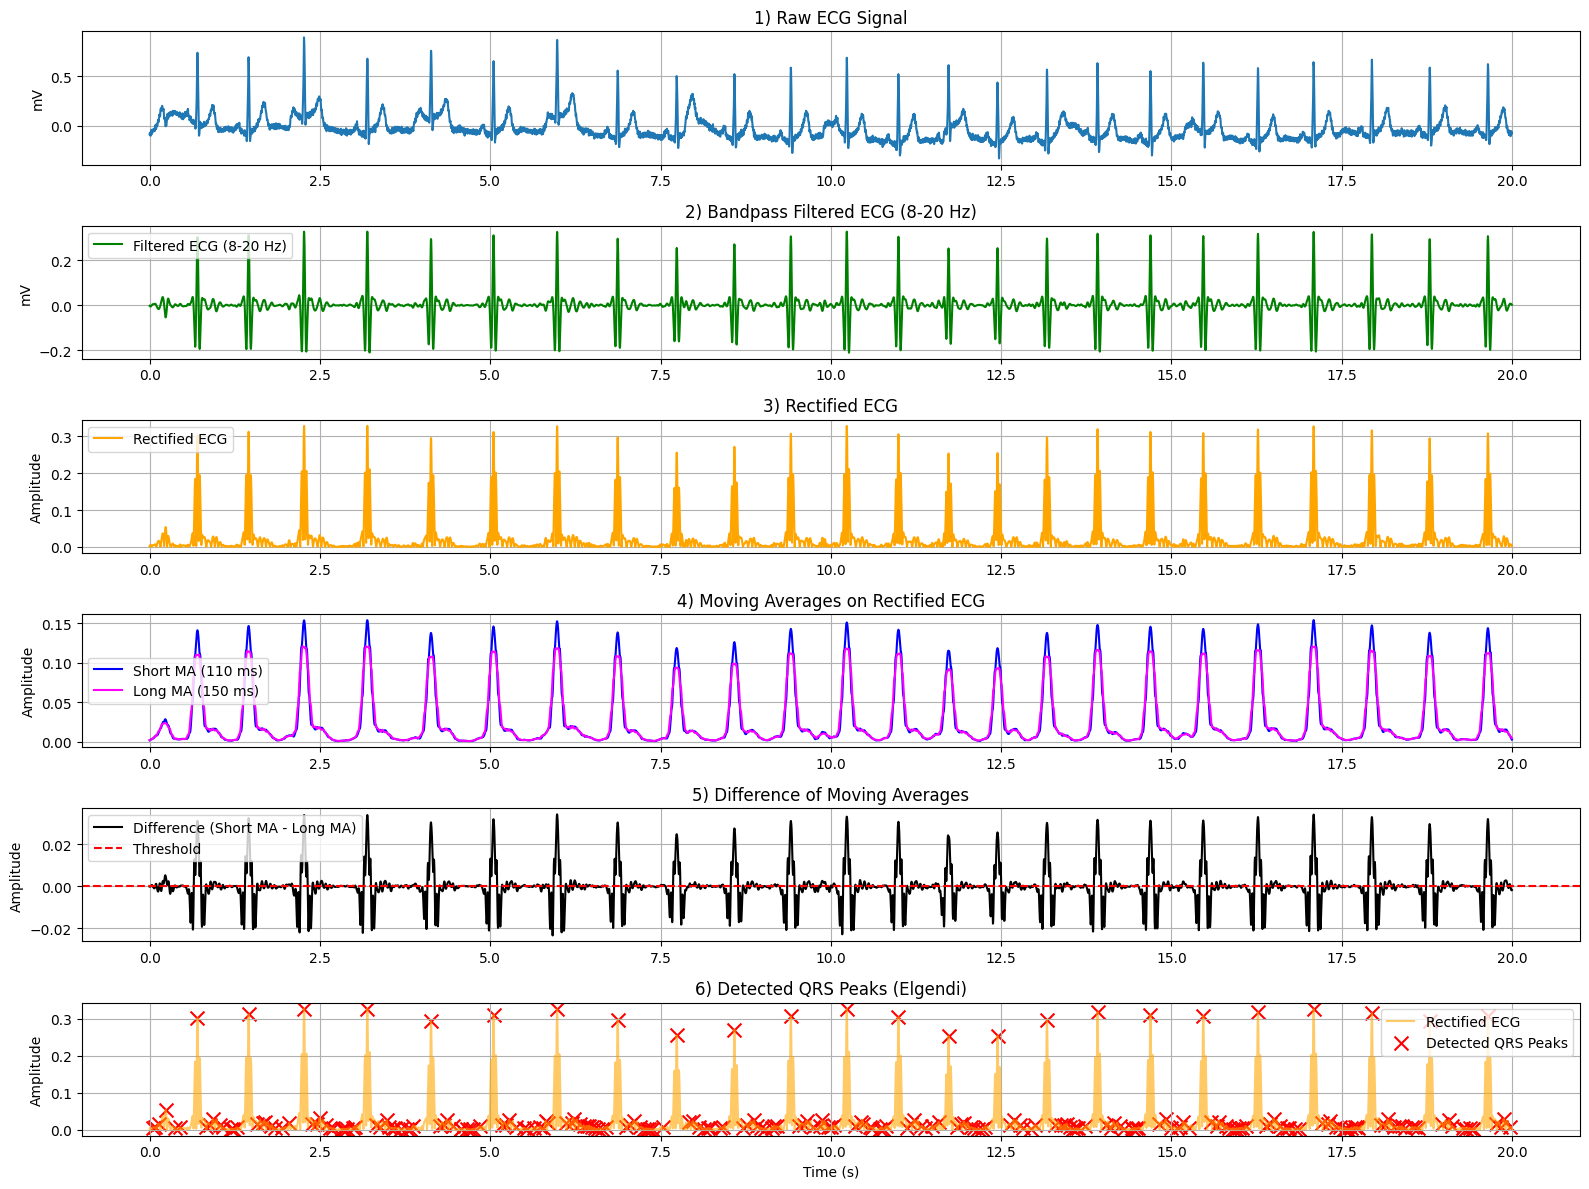

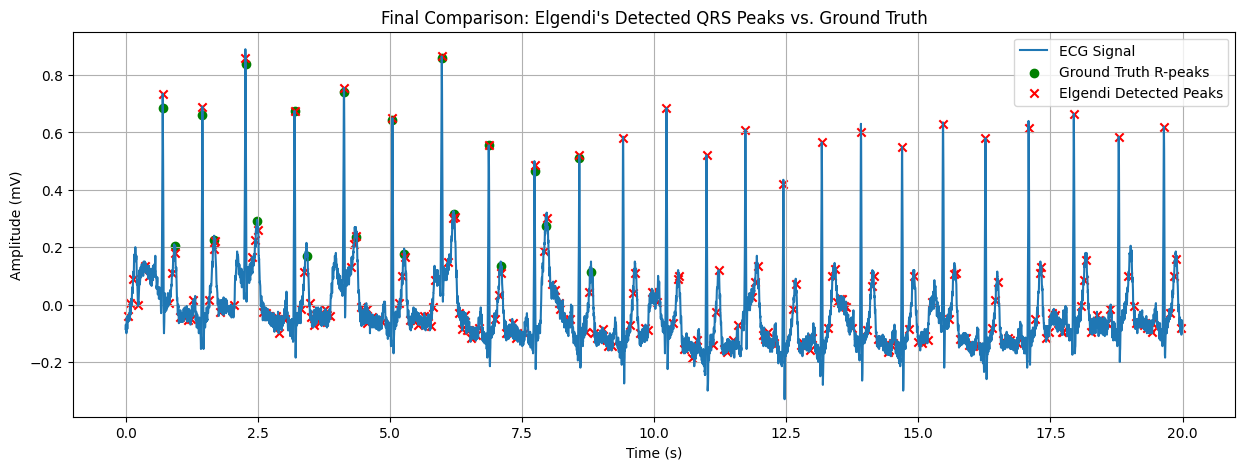

Elgendi QRS Peaks detected: 241
WFDB R-peaks (ground truth): 20


In [24]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import label

def bandpass_filter(sig, fs, lowcut=8, highcut=20, order=2):
    """
    Bandpass filter: default 8-20 Hz (Elgendi's recommended range).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, sig)

def moving_window_integration(sig, window_ms, fs):
    """
    Compute a simple moving average over a window specified in ms.
    """
    window_size = int(window_ms * fs / 1000)
    window = np.ones(window_size) / window_size
    return np.convolve(sig, window, mode='same')

def detect_peaks_elgendi(ecg, fs):
    """
    Elgendi's Fast QRS Detection Algorithm:
      1. Bandpass filter the ECG (8-20 Hz).
      2. Rectify the filtered signal.
      3. Compute two moving averages:
         - Short-term MA with a window of ~110 ms (captures QRS energy).
         - Long-term MA with a window of ~150 ms (suppresses non-QRS components).
      4. Compute the difference: diff_ma = (Short-term MA - Long-term MA).
      5. Identify candidate regions where diff_ma exceeds a threshold (mean value).
      6. Label contiguous candidate regions and select the index with the highest rectified value as the QRS peak.
    Returns:
      - qrs_peaks: indices of detected QRS peaks.
      - intermediate signals for debugging.
    """
    # 1. Bandpass filtering with Elgendi's parameters
    filtered_ecg = bandpass_filter(ecg, fs, lowcut=8, highcut=20, order=2)
    
    # 2. Rectify the filtered signal
    rectified_ecg = np.abs(filtered_ecg)
    
    # 3. Compute moving averages:
    # Short-term moving average (approx. 110 ms window)
    ma_qrs = moving_window_integration(rectified_ecg, window_ms=110, fs=fs)
    # Long-term moving average (approx. 150 ms window)
    ma_long = moving_window_integration(rectified_ecg, window_ms=150, fs=fs)
    
    # 4. Difference between the two moving averages
    diff_ma = ma_qrs - ma_long
    
    # 5. Determine a threshold (here using the mean of diff_ma)
    threshold = np.mean(diff_ma)
    
    # 6. Identify candidate QRS regions where diff_ma exceeds the threshold
    candidate_regions = diff_ma > threshold
    
    # Label contiguous candidate regions and select the peak in each region
    labeled_array, num_features = label(candidate_regions)
    qrs_peaks = []
    for i in range(1, num_features + 1):
        indices = np.where(labeled_array == i)[0]
        if len(indices) == 0:
            continue
        # Within each candidate region, pick the index with maximum rectified ECG value
        peak_idx = indices[np.argmax(rectified_ecg[indices])]
        qrs_peaks.append(peak_idx)
    
    return np.array(qrs_peaks), filtered_ecg, rectified_ecg, ma_qrs, ma_long, diff_ma

# ---------------------------------------------------------------------
# Example usage with WFDB data:
# ---------------------------------------------------------------------
# Adjust the record_path to point to your data.
record_path = "Person_01/rec_1"  # e.g., "mitdb/100" for MIT-BIH
record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(ecg_signal)) / fs

# Ground truth R-peak annotations (if available)
ann = wfdb.rdann(record_path, 'atr')
true_r_peaks = ann.sample

# -------------------------
# Apply Elgendi's QRS Detection Algorithm
# -------------------------
qrs_peaks_elgendi, filtered_ecg, rectified_ecg, ma_qrs, ma_long, diff_ma = detect_peaks_elgendi(ecg_signal, fs)

# ---------------------------------------------------------------------
# Debug/Visualization: Plot each processing stage for Elgendi's algorithm
# ---------------------------------------------------------------------
plt.figure(figsize=(16, 12))

plt.subplot(6, 1, 1)
plt.plot(time, ecg_signal, label='Raw ECG')
plt.title('1) Raw ECG Signal')
plt.ylabel('mV')
plt.grid(True)

plt.subplot(6, 1, 2)
plt.plot(time, filtered_ecg, color='green', label='Filtered ECG (8-20 Hz)')
plt.title('2) Bandpass Filtered ECG (8-20 Hz)')
plt.ylabel('mV')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(time, rectified_ecg, color='orange', label='Rectified ECG')
plt.title('3) Rectified ECG')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(time, ma_qrs, color='blue', label='Short MA (110 ms)')
plt.plot(time, ma_long, color='magenta', label='Long MA (150 ms)')
plt.title('4) Moving Averages on Rectified ECG')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(time, diff_ma, color='black', label='Difference (Short MA - Long MA)')
plt.axhline(np.mean(diff_ma), color='red', linestyle='--', label='Threshold')
plt.title('5) Difference of Moving Averages')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(time, rectified_ecg, color='orange', alpha=0.6, label='Rectified ECG')
plt.scatter(qrs_peaks_elgendi/fs, rectified_ecg[qrs_peaks_elgendi], color='red', marker='x', s=100, label='Detected QRS Peaks')
plt.title('6) Detected QRS Peaks (Elgendi)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Final Comparison with Ground Truth
# ---------------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(true_r_peaks/fs, ecg_signal[true_r_peaks], color='green', marker='o', label='Ground Truth R-peaks')
plt.scatter(qrs_peaks_elgendi/fs, ecg_signal[qrs_peaks_elgendi], color='red', marker='x', label='Elgendi Detected Peaks')
plt.title("Final Comparison: Elgendi's Detected QRS Peaks vs. Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

print("Elgendi QRS Peaks detected:", len(qrs_peaks_elgendi))
print("WFDB R-peaks (ground truth):", len(true_r_peaks))


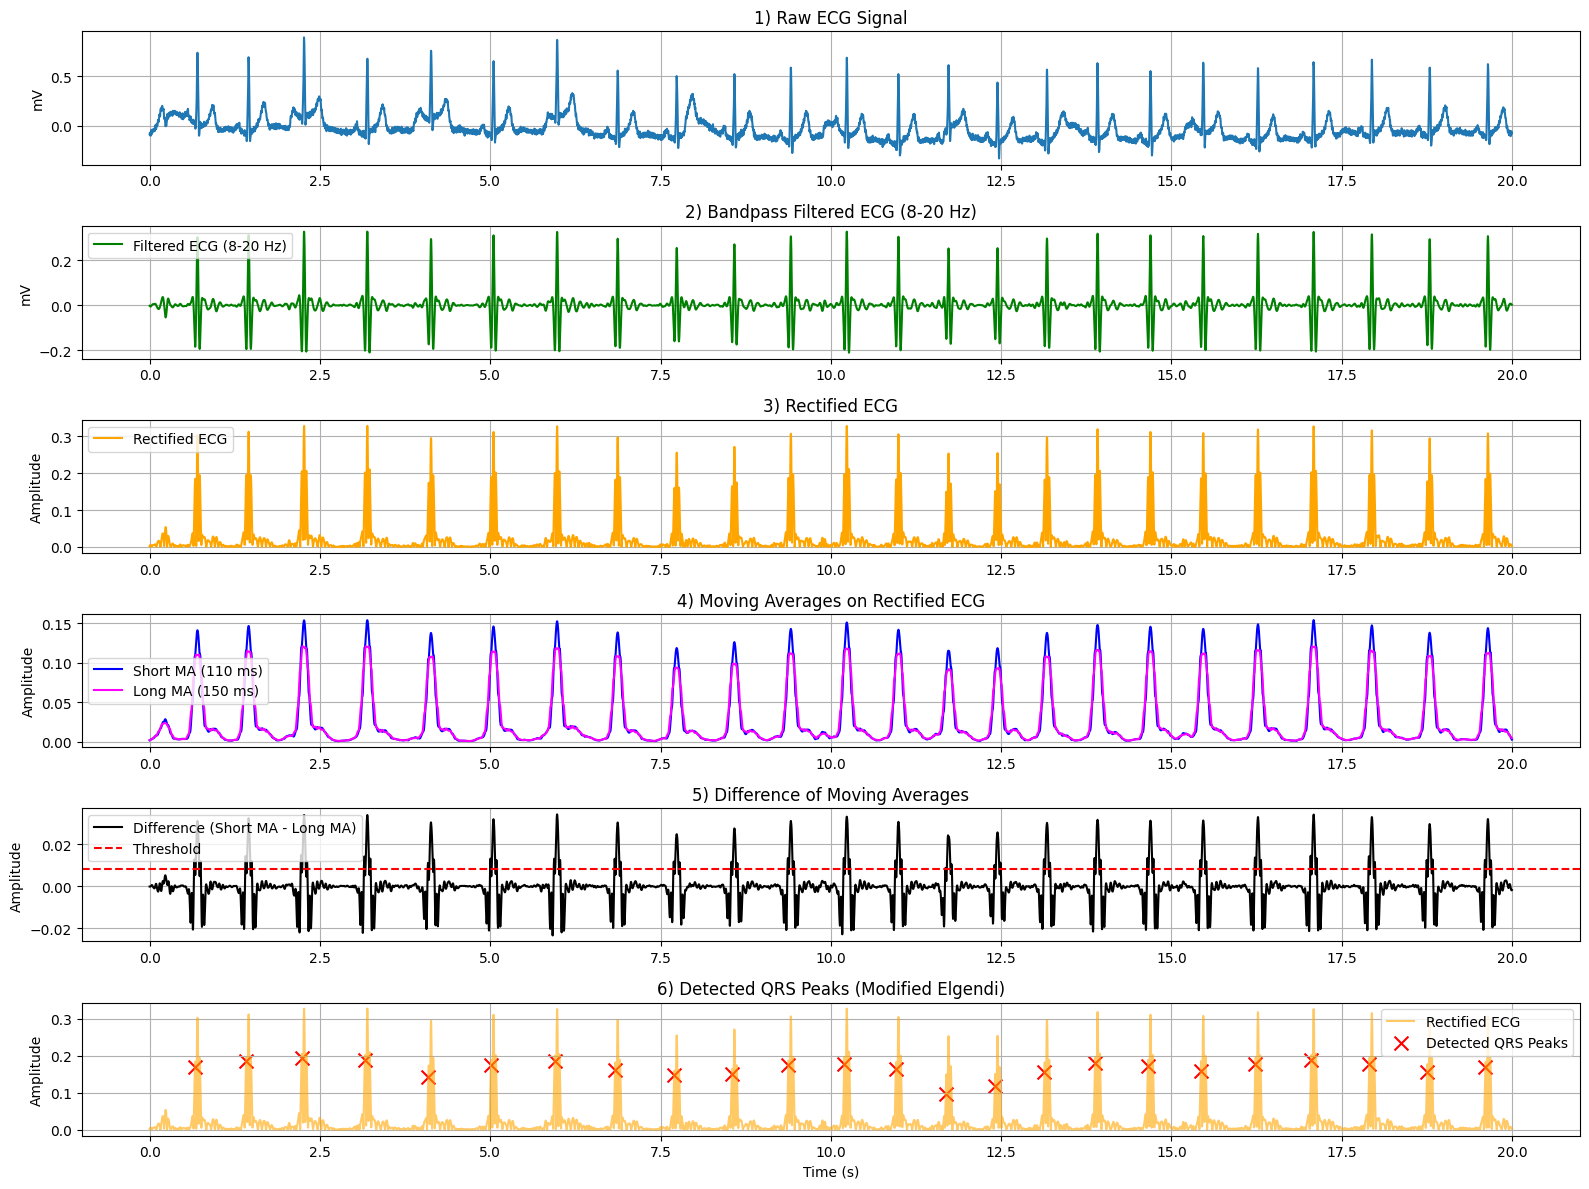

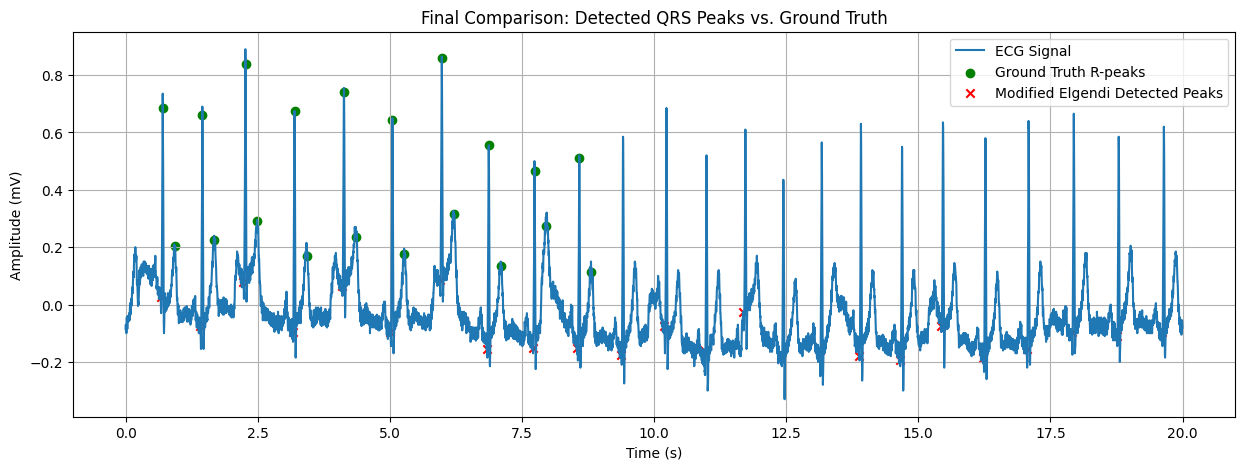

Modified Elgendi QRS Peaks detected: 24
WFDB R-peaks (ground truth): 20


In [25]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import label

def bandpass_filter(sig, fs, lowcut=8, highcut=20, order=2):
    """
    Bandpass filter: default 8-20 Hz (Elgendi's recommended range).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, sig)

def moving_window_integration(sig, window_ms, fs):
    """
    Compute a simple moving average over a window specified in ms.
    """
    window_size = int(window_ms * fs / 1000)
    window = np.ones(window_size) / window_size
    return np.convolve(sig, window, mode='same')

def detect_peaks_elgendi(ecg, fs):
    """
    Modified Elgendi's Fast QRS Detection Algorithm:
      1. Bandpass filter the ECG (8-20 Hz).
      2. Rectify the filtered signal.
      3. Compute two moving averages:
         - Short-term MA with a window of ~110 ms.
         - Long-term MA with a window of ~150 ms.
      4. Compute the difference: diff_ma = (Short MA - Long MA).
      5. Set threshold = mean(diff_ma) + std(diff_ma) to be more stringent.
      6. Identify candidate regions where diff_ma exceeds the threshold.
      7. Label contiguous candidate regions and pick the index with the highest rectified value as the QRS peak.
      8. Enforce a refractory period of 0.3 s between detected peaks.
    Returns:
      - qrs_peaks: indices of detected QRS peaks.
      - Intermediate signals for debugging.
    """
    # 1. Bandpass filtering with Elgendi's parameters
    filtered_ecg = bandpass_filter(ecg, fs, lowcut=8, highcut=20, order=2)
    
    # 2. Rectify the filtered signal
    rectified_ecg = np.abs(filtered_ecg)
    
    # 3. Compute moving averages:
    ma_qrs = moving_window_integration(rectified_ecg, window_ms=110, fs=fs)  # short-term MA
    ma_long = moving_window_integration(rectified_ecg, window_ms=150, fs=fs)  # long-term MA
    
    # 4. Difference between the two moving averages
    diff_ma = ma_qrs - ma_long
    
    # 5. Set a more stringent threshold
    threshold = np.mean(diff_ma) + np.std(diff_ma)
    
    # 6. Identify candidate QRS regions where diff_ma exceeds the threshold
    candidate_regions = diff_ma > threshold
    
    # Label contiguous candidate regions and select the peak within each region
    labeled_array, num_features = label(candidate_regions)
    qrs_peaks = []
    for i in range(1, num_features + 1):
        indices = np.where(labeled_array == i)[0]
        if len(indices) == 0:
            continue
        # Within each candidate region, choose the index with the maximum rectified ECG value
        peak_idx = indices[np.argmax(rectified_ecg[indices])]
        qrs_peaks.append(peak_idx)
    
    qrs_peaks = np.array(qrs_peaks)
    
    # 7. Enforce a refractory period (minimum distance of 0.3 seconds between peaks)
    refractory_period = int(0.3 * fs)
    if len(qrs_peaks) > 0:
        filtered_peaks = [qrs_peaks[0]]
        for peak in qrs_peaks[1:]:
            if peak - filtered_peaks[-1] > refractory_period:
                filtered_peaks.append(peak)
        qrs_peaks = np.array(filtered_peaks)
    
    return qrs_peaks, filtered_ecg, rectified_ecg, ma_qrs, ma_long, diff_ma

# ---------------------------------------------------------------------
# Example usage with WFDB data:
# ---------------------------------------------------------------------
record_path = "Person_01/rec_1"  # e.g., "mitdb/100" if using MIT-BIH database
record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(ecg_signal)) / fs

# Ground truth R-peak annotations (if available)
ann = wfdb.rdann(record_path, 'atr')
true_r_peaks = ann.sample

# -------------------------
# Apply Modified Elgendi's QRS Detection Algorithm
# -------------------------
qrs_peaks_elgendi, filtered_ecg, rectified_ecg, ma_qrs, ma_long, diff_ma = detect_peaks_elgendi(ecg_signal, fs)

# ---------------------------------------------------------------------
# Debug/Visualization: Plot each processing stage for the modified algorithm
# ---------------------------------------------------------------------
plt.figure(figsize=(16, 12))

plt.subplot(6, 1, 1)
plt.plot(time, ecg_signal, label='Raw ECG')
plt.title('1) Raw ECG Signal')
plt.ylabel('mV')
plt.grid(True)

plt.subplot(6, 1, 2)
plt.plot(time, filtered_ecg, color='green', label='Filtered ECG (8-20 Hz)')
plt.title('2) Bandpass Filtered ECG (8-20 Hz)')
plt.ylabel('mV')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(time, rectified_ecg, color='orange', label='Rectified ECG')
plt.title('3) Rectified ECG')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(time, ma_qrs, color='blue', label='Short MA (110 ms)')
plt.plot(time, ma_long, color='magenta', label='Long MA (150 ms)')
plt.title('4) Moving Averages on Rectified ECG')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(time, diff_ma, color='black', label='Difference (Short MA - Long MA)')
plt.axhline(np.mean(diff_ma) + np.std(diff_ma), color='red', linestyle='--', label='Threshold')
plt.title('5) Difference of Moving Averages')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(time, rectified_ecg, color='orange', alpha=0.6, label='Rectified ECG')
plt.scatter(qrs_peaks_elgendi/fs, rectified_ecg[qrs_peaks_elgendi], color='red', marker='x', s=100, label='Detected QRS Peaks')
plt.title('6) Detected QRS Peaks (Modified Elgendi)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Final Comparison with Ground Truth
# ---------------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(true_r_peaks/fs, ecg_signal[true_r_peaks], color='green', marker='o', label='Ground Truth R-peaks')
plt.scatter(qrs_peaks_elgendi/fs, ecg_signal[qrs_peaks_elgendi], color='red', marker='x', label='Modified Elgendi Detected Peaks')
plt.title("Final Comparison: Detected QRS Peaks vs. Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

print("Modified Elgendi QRS Peaks detected:", len(qrs_peaks_elgendi))
print("WFDB R-peaks (ground truth):", len(true_r_peaks))
